Загрузка данных 

In [ ]:
import pandas as pd
import ast

# Загрузка данных с обработкой возможных ошибок
try:
    df = pd.read_csv('categorized_comments.csv', encoding='utf-8-sig', on_bad_lines='warn')
except pd.errors.ParserError:
    df = pd.read_csv('categorized_comments.csv', encoding='utf-8-sig', on_bad_lines='skip')

# Список всех категорий для преобразования
categories_list = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Вопрос не решен'
]

# Функция для преобразования строки с категориями в список
def parse_categories(cat_str):
    if pd.isna(cat_str):
        return []
    try:
        # Удаляем лишние пробелы и кавычки
        cat_str = str(cat_str).strip()
        if not cat_str or cat_str == '[]':
            return []
        
        # Пробуем преобразовать строку в список
        if cat_str.startswith('[') and cat_str.endswith(']'):
            try:
                return ast.literal_eval(cat_str)
            except:
                # Если не получается, обрабатываем вручную
                return [c.strip(" '\"") for c in cat_str.strip("[]").split(",") if c.strip()]
        return [cat_str]
    except:
        return []

# Применяем функцию к столбцу categories
df['categories_parsed'] = df['categories'].apply(parse_categories)

# Создаем бинарные столбцы для каждой категории
for category in categories_list:
    df[category] = df['categories_parsed'].apply(lambda x: 1 if category in x else 0)

# Удаляем временные столбцы
df.drop(['categories', 'categories_parsed'], axis=1, inplace=True, errors='ignore')

# Переименовываем столбцы для удобства (по желанию)
column_rename = {
    'Нравится скорость отработки заявок': 'Скорость',
    'Нравится качество выполнения заявки': 'Качество выполнения',
    'Нравится качество работы сотрудников': 'Качество сотрудников',
    'Понравилось выполнение заявки': 'Выполнение заявки',
    'Вопрос решен': 'Вопрос решен',
    'Вопрос не решен': 'Вопрос не решен'
}
df.rename(columns=column_rename, inplace=True)

# Сохраняем результат
output_columns = ['id', 'rating', 'comment'] + list(column_rename.values())
df[output_columns].to_csv('comments_with_binary_categories.csv', index=False, encoding='utf-8-sig')

# Выводим первые 5 строк для проверки
print(df[output_columns].head())

        id  rating                                       comment  Скорость  \
0  2945792       5                                       спасибо         0   
1  3234340       5                                      спасибо!         0   
2  3380332       5                                      Отлично          0   
3  3381812       5  Благодарю за оперативное решение проблемы !          1   
4  3691620       5                                      Спасибо          0   

   Качество выполнения  Качество сотрудников  Выполнение заявки  Вопрос решен  \
0                    0                     0                  0             1   
1                    0                     0                  0             1   
2                    1                     0                  0             0   
3                    0                     0                  1             1   
4                    0                     0                  0             1   

   Вопрос не решен  
0                0  
1 

C:\Users\Vlad\AppData\Local\Temp\ipykernel_15136\650862485.py:8: ParserWarning: Skipping line 6: expected 9 fields, saw 11

  df = pd.read_csv('categorized_comments.csv', encoding='utf-8-sig', on_bad_lines='warn')


Пропуски в данных:
id                      0
rating                  0
comment                 0
Скорость                0
Качество выполнения     0
Качество сотрудников    0
Выполнение заявки       0
Вопрос решен            0
Вопрос не решен         0
dtype: int64

Доступные категории: ['Скорость', 'Качество выполнения', 'Качество сотрудников', 'Выполнение заявки', 'Вопрос решен', 'Вопрос не решен']

Распределение оценок:
rating
1      13
2       3
3       5
4      12
5    2224
Name: count, dtype: int64

Распределение целевой переменной:
target
1    0.990696
0    0.009304
Name: proportion, dtype: float64

Корреляция признаков:


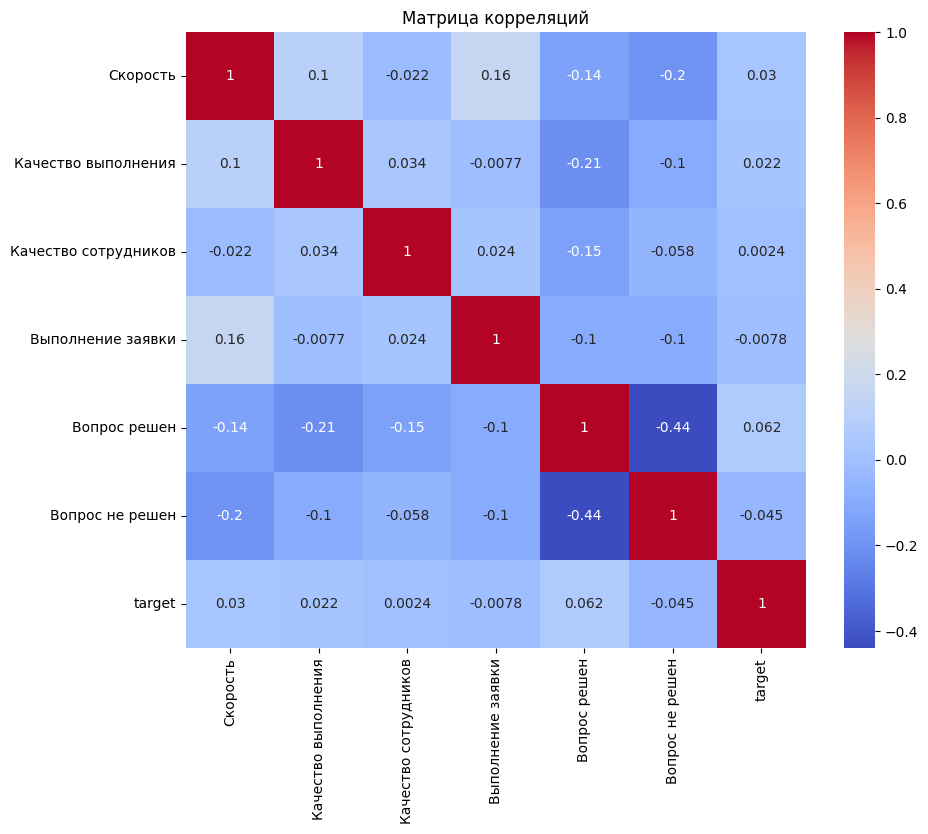

NameError: name 'train_and_evaluate' is not defined

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, 
                             confusion_matrix, classification_report,
                             r2_score, mean_squared_error)
from sklearn.model_selection import GridSearchCV

# 1. Загрузка и предобработка данных
def load_and_preprocess(file_path):
    # Загрузка данных
    try:
        df = pd.read_csv("comments_with_binary_categories.csv", encoding='utf-8-sig', on_bad_lines='warn')
    except:
        df = pd.read_csv("comments_with_binary_categories.csv", encoding='utf-8-sig', on_bad_lines='skip')
    
    # Проверка пропусков
    print("Пропуски в данных:")
    print(df.isnull().sum())
    
    # Удаление строк с пропусками в ключевых столбцах
    df = df.dropna(subset=['rating', 'comment'])
    
    # Список категорий (бинарных столбцов)
    categories_list = [
        'Скорость',
        'Качество выполнения',
        'Качество сотрудников',
        'Выполнение заявки',
        'Вопрос решен',
        'Вопрос не решен'
    ]
    
    # Проверяем наличие всех категорий в данных
    available_categories = [col for col in categories_list if col in df.columns]
    print("\nДоступные категории:", available_categories)
    
    # Создание целевой переменной (пример: 1 если rating >= 4, иначе 0)
    df['target'] = df['rating'].apply(lambda x: 1 if x >= 4 else 0)
    
    return df, available_categories

# 2. Анализ данных
def explore_data(df, categories_list):
    print("\nРаспределение оценок:")
    print(df['rating'].value_counts().sort_index())
    
    print("\nРаспределение целевой переменной:")
    print(df['target'].value_counts(normalize=True))
    
    if categories_list:  # Проверяем, есть ли категории для анализа
        print("\nКорреляция признаков:")
        plt.figure(figsize=(10, 8))
        sns.heatmap(df[categories_list + ['target']].corr(), annot=True, cmap='coolwarm')
        plt.title("Матрица корреляций")
        plt.show()
    else:
        print("\nНет категорий для анализа корреляции")

# 3. Подготовка данных для моделирования
def prepare_data(df, categories_list):
    if not categories_list:
        raise ValueError("Нет признаков для обучения модели")
    
    # Признаки и целевая переменная
    X = df[categories_list]
    y = df['target']
    
    # Разделение на train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Масштабирование числовых признаков
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

# ... (остальные функции остаются без изменений) ...

# Основной пайплайн
def main():
    # 1. Загрузка и предобработка
    file_path = 'comments_with_binary_categories.csv'
    df, categories_list = load_and_preprocess(file_path)
    
    # 2. Анализ данных
    explore_data(df, categories_list)
    
    # 3. Подготовка данных
    try:
        X_train, X_test, y_train, y_test, scaler = prepare_data(df, categories_list)
    except ValueError as e:
        print(f"Ошибка: {e}")
        return
    
    # 4. Обучение и оценка моделей
    results = train_and_evaluate(X_train, X_test, y_train, y_test)
    
    # 5. Оптимизация лучшей модели
    best_model = optimize_model(X_train, y_train)
    
    # Оценка оптимизированной модели
    y_pred_optimized = best_model.predict(X_test)
    y_proba_optimized = best_model.predict_proba(X_test)[:, 1]
    
    print("\n=== Оптимизированная модель ===")
    print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_optimized):.4f}")
    print(classification_report(y_test, y_pred_optimized))
    
    # Важность признаков
    plt.figure(figsize=(10, 6))
    feature_importances = pd.Series(
        best_model.feature_importances_,
        index=categories_list
    ).sort_values(ascending=False)
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Важность признаков')
    plt.xlabel('Важность')
    plt.ylabel('Признаки')
    plt.show()

if __name__ == "__main__":
    main()